In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc
# Generate mock customer data

np.random.seed(42)

num_customers = 2000



data = {

    'CustomerID': [f'CUST{1000+i}' for i in range(num_customers)],

    'Gender': np.random.choice(['Male', 'Female'], num_customers, p=[0.5, 0.5]),

    'SeniorCitizen': np.random.choice([0, 1], num_customers, p=[0.84, 0.16]),

    'Partner': np.random.choice(['Yes', 'No'], num_customers, p=[0.48, 0.52]),

    'Dependents': np.random.choice(['Yes', 'No'], num_customers, p=[0.3, 0.7]),

    'Tenure': np.random.randint(1, 73, num_customers), # Months

    'PhoneService': np.random.choice(['Yes', 'No'], num_customers, p=[0.9, 0.1]),

    'MultipleLines': np.random.choice(['Yes', 'No', 'No phone service'], num_customers, p=[0.42, 0.48, 0.1]),

    'InternetService': np.random.choice(['DSL', 'Fiber optic', 'No'], num_customers, p=[0.34, 0.44, 0.22]),

    'OnlineSecurity': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.28, 0.50, 0.22]),

    'OnlineBackup': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.34, 0.44, 0.22]),

    'DeviceProtection': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.34, 0.44, 0.22]),

    'TechSupport': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.29, 0.49, 0.22]),

    'StreamingTV': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.38, 0.40, 0.22]),

    'StreamingMovies': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.39, 0.39, 0.22]),

    'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], num_customers, p=[0.55, 0.24, 0.21]),

    'PaperlessBilling': np.random.choice(['Yes', 'No'], num_customers, p=[0.59, 0.41]),

    'PaymentMethod': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'], num_customers, p=[0.34, 0.23, 0.22, 0.21]),

    'MonthlyCharges': np.random.normal(loc=65, scale=30, size=num_customers).clip(18, 120).round(2),

}

df_customers = pd.DataFrame(data)



# Generate TotalCharges based on Tenure and MonthlyCharges with some noise

df_customers['TotalCharges'] = (df_customers['Tenure'] * df_customers['MonthlyCharges'] * np.random.uniform(0.95, 1.05, num_customers)).round(2)

# Make some TotalCharges empty for realism (e.g., new customers with 0 tenure)

df_customers.loc[df_customers['Tenure'] == 1, 'TotalCharges'] = df_customers['MonthlyCharges']

# Create a boolean mask for the rows to set to NaN

nan_mask = np.zeros(num_customers, dtype=bool)

nan_indices = np.random.choice(df_customers.index, size=int(num_customers*0.01), replace=False)

nan_mask[nan_indices] = True



df_customers.loc[nan_mask & (df_customers['Tenure'] < 3), 'TotalCharges'] = np.nan





# Simulate Churn (more likely for month-to-month, higher charges, lower tenure)

churn_probability = 0.1 \

+ 0.15 * (df_customers['Contract'] == 'Month-to-month') \

+ 0.1 * (df_customers['InternetService'] == 'Fiber optic') \

+ 0.001 * (df_customers['MonthlyCharges'] - 65) \

- 0.002 * (df_customers['Tenure'] - 36) \

+ 0.1 * (df_customers['OnlineSecurity'] == 'No') \

+ 0.1 * (df_customers['TechSupport'] == 'No')



churn_probability = np.clip(churn_probability, 0.01, 0.99)

df_customers['Churn'] = np.random.binomial(1, churn_probability, num_customers).astype(str)

df_customers['Churn'] = df_customers['Churn'].replace({'1': 'Yes', '0': 'No'})



# Replace 'No phone service' and 'No internet service' for consistency

for col in ['MultipleLines']:

    df_customers[col] = df_customers.apply(lambda row: 'No' if row['PhoneService'] == 'No' else row[col], axis=1)



for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:

    df_customers[col] = df_customers.apply(lambda row: 'No' if row['InternetService'] == 'No' else row[col], axis=1)

# Save to CSV

df_customers.to_csv('telecom_churn_mock_data.csv', index=False)
print("Mock telecom churn data generated: telecom_churn_mock_data.csv")
print(df_customers.head())
print(f"\nChurn distribution:\n{df_customers['Churn'].value_counts(normalize=True)}")
from google.colab import files
files.download('telecom_churn_mock_data.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        2000 non-null   object 
 1   Gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   Tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


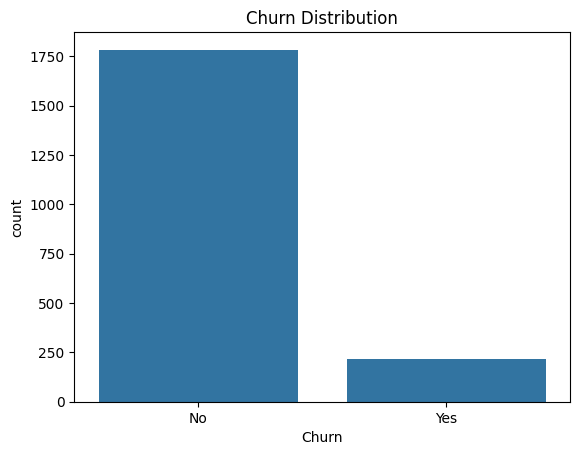

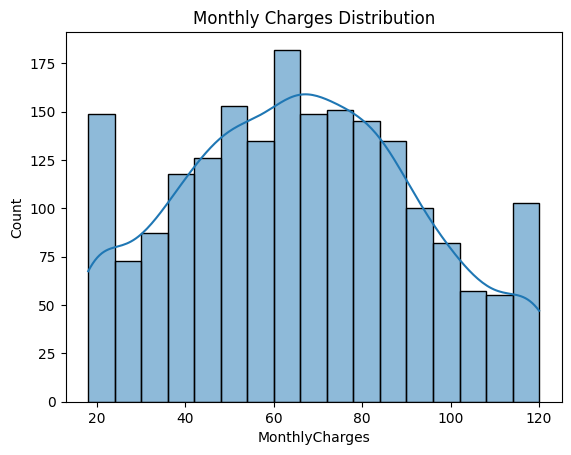

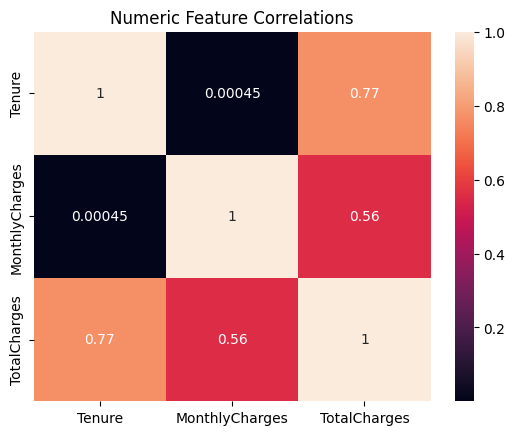

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.88      0.56      0.68       344
           1       0.16      0.52      0.25        56

    accuracy                           0.56       400
   macro avg       0.52      0.54      0.47       400
weighted avg       0.78      0.56      0.62       400

ROC-AUC: 0.5223214285714285
Best Logistic Regression params: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Random Forest Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88       344
           1       0.15      0.11      0.12        56

    accuracy                           0.79       400
   macro avg       0.50      0.50      0.50       400
weighted avg       0.76      0.79      0.77       400

ROC-AUC: 0.5058139534883721
Best Random Forest params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


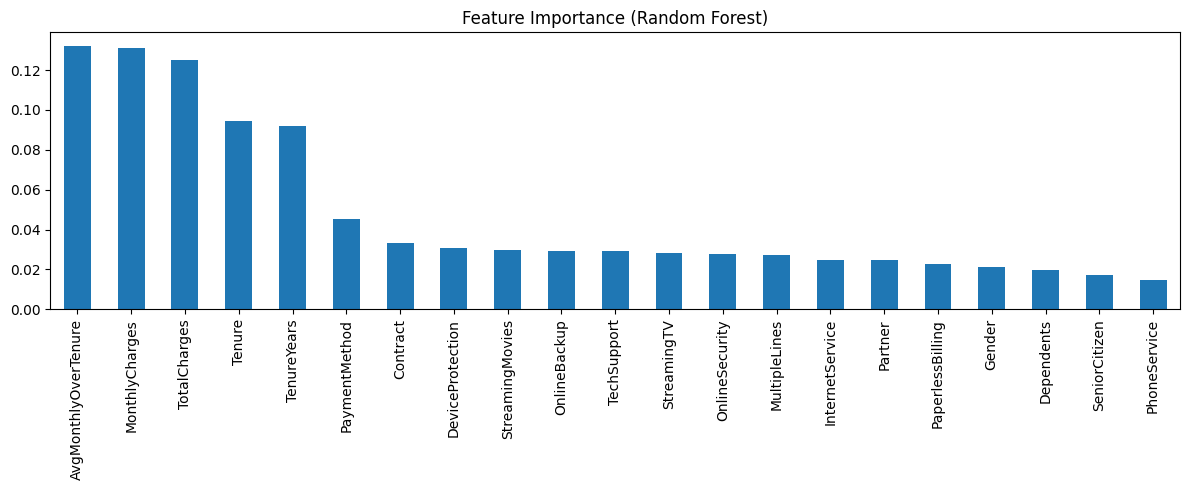

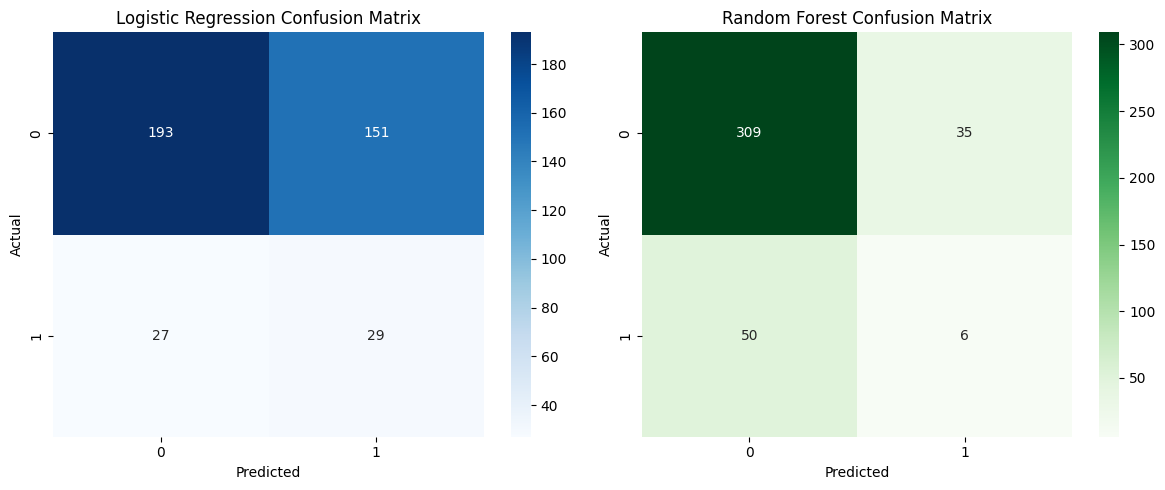

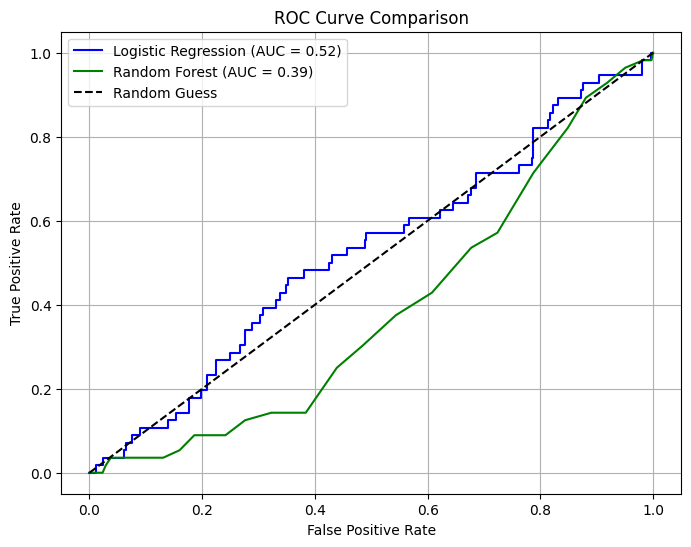

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

# ---- Load data ----
df = df_customers.copy()  # if already in memory. Otherwise, use: pd.read_csv('mock_telecom_churn.csv')

# ---- EDA ----
print(df.info())
print(df.describe())
print(df.isnull().sum())
sns.countplot(data=df, x='Churn'); plt.title("Churn Distribution"); plt.show()
sns.histplot(df['MonthlyCharges'], kde=True); plt.title("Monthly Charges Distribution"); plt.show()

# Correlation of numerical features
numeric_cols = ['Tenure', 'MonthlyCharges', 'TotalCharges']
sns.heatmap(df[numeric_cols].corr(), annot=True); plt.title("Numeric Feature Correlations"); plt.show()

# ---- Handle Missing Data ----
imputer = SimpleImputer(strategy='median')
df['TotalCharges'] = imputer.fit_transform(df[['TotalCharges']])

# ---- Encode Categorical Variables ----
df_encoded = df.copy()
le = LabelEncoder()
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col != 'CustomerID':
        df_encoded[col] = le.fit_transform(df_encoded[col])

# ---- Feature Engineering ----
df_encoded['TenureYears'] = (df_encoded['Tenure'] / 12).round(1)
df_encoded['AvgMonthlyOverTenure'] = (df_encoded['TotalCharges'] / df_encoded['Tenure']).fillna(0).round(2)

# ---- Feature Selection ----
features = [col for col in df_encoded.columns if col not in ['CustomerID', 'Churn']]
X = df_encoded[features]
y = df_encoded['Churn']

# ---- Train/Test Split ----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- Scale Features ----
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---- Model 1: Logistic Regression ----
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1]))

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # supports both l1 and l2
}

grid_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
print("Best Logistic Regression params:", grid_lr.best_params_)

# ---- Model 2: Random Forest ----
rf = RandomForestClassifier(class_weight='balanced',random_state=42)
param_grid = {'n_estimators': [50, 100], 'max_depth': [5, 10, None]}
grid_rf = GridSearchCV(rf, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]))

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print("Best Random Forest params:", grid_rf.best_params_)

# ---- Feature Importance from Best Model ----
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,5), title='Feature Importance (Random Forest)'); plt.tight_layout(); plt.show()

# ---- Confusion Matrices ----
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Logistic Regression Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title('Random Forest Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ---- ROC Curves ----
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr.predict_proba(X_test_scaled)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc(fpr_lr, tpr_lr):.2f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc(fpr_rf, tpr_rf):.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
import joblib
joblib.dump(best_rf, 'best_model.pkl')
from google.colab import files
files.download('best_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>